In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/JohnsHopkins.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = ld_coord[idx[i],1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_JH', ref_nodes) 
            np.save('results/info_ref_nodes_JH', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 1 Feature value  217.0  gap  [0.76972008]  volume:  10696.0  size: 200 conductance:  0.262341062079282
Reached
Number of feature 2 Feature value  2008.0  gap  [0.86957805]  volume:  82875.0  size: 912 conductance:  0.3928446455505279
Reached
Number of feature 2 Feature value  2009.0  gap  [0.83656915]  volume:  32454.0  size: 886 conductance:  0.19757194798792135


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [6]:
ref_nodes = np.load('results/ref_nodes_JH.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_JH.npy') 

## Visualize the ground truth clusters

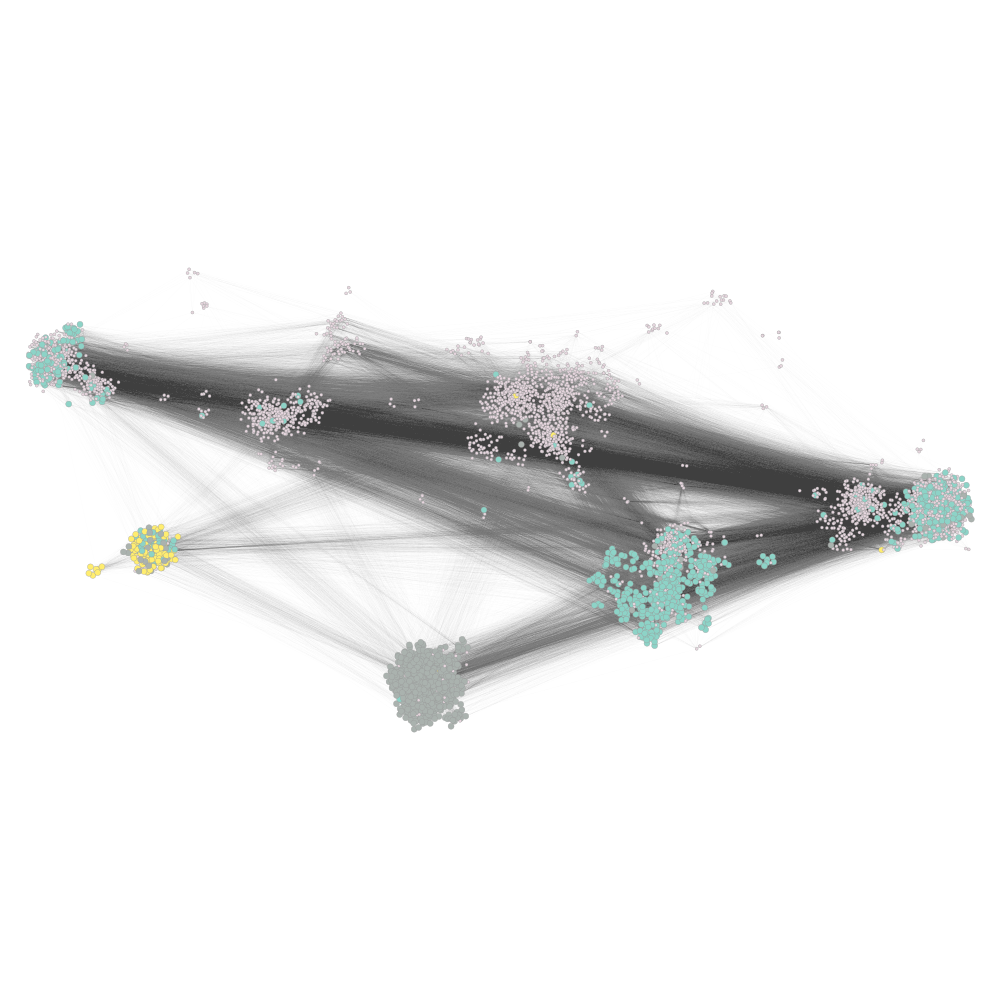

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14300b908, at 0x12e20d550>

In [7]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [8]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            rho = 0.2/sum(g.d[rr])

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_JH', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_JH', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_JH', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_JH', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_JH', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_JH', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_JH', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_JH', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_JH', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_JH', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_JH', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_JH', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_JH', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_JH', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_JH', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_JH', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_JH', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_JH', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_JH', cuts_acl_ALL) 
    
    np.save('results/nodes_JH', nodes)

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.24259622329996905 f1score:  0.8365134644626477 precision:  0.8798885563925292 recall:  0.7972139117427075
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.18402590393955748 f1score:  0.9413220867332904 precision:  0.9234574563770462 recall:  0.9598915482423336
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.20800790017057186 f1score:  0.9089993130295397 precision:  0.8909237813089146 recall:  0.9278234854151085
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.27177334732423925 f1score:  0.8598657136668832 precision:  0.8011138913552345 recall:  0.9279169783096485
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.2334189742125797 f1score:  0.8689513541265562 precision:  0.8010570324209197 recall:  0.9494203440538519
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduc

outer: 0 number of node:  4515  completed:  0.45  degree:  21.0
conductance:  0.34858967535923363 f1score:  0.7917313094888675 precision:  0.7177830152816848 recall:  0.8826664173522812
outer: 0 number of node:  947  completed:  0.46  degree:  92.0
conductance:  0.19519519519519518 f1score:  0.8943336980826871 precision:  0.9104911362975879 recall:  0.8787397157816006
outer: 0 number of node:  2811  completed:  0.47  degree:  31.0
conductance:  0.18290221977618787 f1score:  0.9404574497638671 precision:  0.9315721885892497 recall:  0.949513836948392
outer: 0 number of node:  4639  completed:  0.48  degree:  55.0
conductance:  0.4129718967761697 f1score:  0.7238897074300148 precision:  0.6583965081552952 recall:  0.8038519072550486
outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.20014044943820225 f1score:  0.9195943498732343 precision:  0.891502808988764 recall:  0.949513836948392
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance

outer: 0 number of node:  3954  completed:  0.92  degree:  32.0
conductance:  0.3812457221081451 f1score:  0.7642065761258042 precision:  0.731776180698152 recall:  0.799644727000748
outer: 0 number of node:  1131  completed:  0.93  degree:  48.0
conductance:  0.20899192132068845 f1score:  0.9197609128781018 precision:  0.8918159466104671 recall:  0.949513836948392
outer: 0 number of node:  3368  completed:  0.94  degree:  37.0
conductance:  0.2194528875379939 f1score:  0.894241592003962 precision:  0.862440295267043 recall:  0.9284779356768885
outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.38863621805137405 f1score:  0.7790321967537158 precision:  0.6563961309333163 recall:  0.9580216903515333
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.21314477566385187 f1score:  0.8754893578724745 precision:  0.8439316387611694 recall:  0.9094988780852655
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductance:  

outer: 1 number of node:  1700  completed:  0.07894736842105263  degree:  126.0
conductance:  0.4698838773871847 f1score:  0.5986597865931962 precision:  0.5798215759658981 recall:  0.618763197586727
outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.5331619671446652 f1score:  0.4116127738004188 precision:  0.42835892952674226 recall:  0.3961266968325792
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.39285678744514213 f1score:  0.5735430459964441 precision:  0.5232816185178182 recall:  0.6344856711915535
outer: 1 number of node:  1027  completed:  0.08552631578947369  degree:  84.0
conductance:  0.4831878771558319 f1score:  0.6969472328221084 precision:  0.7019719206335606 recall:  0.6919939668174963
outer: 1 number of node:  4727  completed:  0.08771929824561403  degree:  53.0
conductance:  0.4902949830625819 f1score:  0.6819328167268153 precision:  0.690317236604604 recall:  0.673749622926093

outer: 1 number of node:  4249  completed:  0.16885964912280702  degree:  39.0
conductance:  0.4995183788990498 f1score:  0.6504797383898518 precision:  0.6457765991604334 recall:  0.6552518853695324
outer: 1 number of node:  279  completed:  0.17105263157894737  degree:  238.0
conductance:  0.4930492954405276 f1score:  0.610612323023274 precision:  0.605422972908858 recall:  0.6158914027149321
outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.4855706892792803 f1score:  0.7063708652896061 precision:  0.6890497882936121 recall:  0.7245852187028657
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.5555555555555556 f1score:  7.238246896601644e-05 precision:  0.16666666666666666 recall:  3.6199095022624436e-05
outer: 1 number of node:  3766  completed:  0.17763157894736842  degree:  45.0
conductance:  0.5279871381170113 f1score:  0.5209173623487479 precision:  0.5065848736046339 recall:  0.536084464555

outer: 1 number of node:  1617  completed:  0.26096491228070173  degree:  12.0
conductance:  0.5597372870633432 f1score:  0.6192422297337087 precision:  0.6047688609254764 recall:  0.6344253393665158
outer: 1 number of node:  4445  completed:  0.2631578947368421  degree:  120.0
conductance:  0.4863759240209564 f1score:  0.6492668656931587 precision:  0.6464438649793067 recall:  0.6521146304675717
outer: 1 number of node:  3217  completed:  0.26535087719298245  degree:  69.0
conductance:  0.5473196404452517 f1score:  0.5251749536321026 precision:  0.5159750360951981 recall:  0.534708898944193
outer: 1 number of node:  2088  completed:  0.2675438596491228  degree:  117.0
conductance:  0.19876341152936897 f1score:  0.05622973983874989 precision:  0.2023480146563972 recall:  0.03265158371040724
outer: 1 number of node:  4119  completed:  0.26973684210526316  degree:  27.0
conductance:  0.4830119161439265 f1score:  0.5271434585895483 precision:  0.518258983746473 recall:  0.5363378582202112

outer: 1 number of node:  3159  completed:  0.35526315789473684  degree:  80.0
conductance:  0.4874996992227917 f1score:  0.6677871958456079 precision:  0.6668110397266537 recall:  0.6687662141779789
outer: 1 number of node:  5146  completed:  0.3574561403508772  degree:  53.0
conductance:  0.49789365820334736 f1score:  0.5667789461351455 precision:  0.5507913013776614 recall:  0.5837224736048265
outer: 1 number of node:  1461  completed:  0.35964912280701755  degree:  127.0
conductance:  0.5311357062606077 f1score:  0.18500817910639256 precision:  0.2757631534912629 recall:  0.1391975867269985
outer: 1 number of node:  1835  completed:  0.3618421052631579  degree:  25.0
conductance:  0.5177525978712922 f1score:  0.5781920332867101 precision:  0.5635919938590562 recall:  0.5935686274509804
outer: 1 number of node:  4384  completed:  0.36403508771929827  degree:  43.0
conductance:  0.5113841873405982 f1score:  0.6702338368758683 precision:  0.6570832367261766 recall:  0.683921568627451


outer: 1 number of node:  3028  completed:  0.4451754385964912  degree:  375.0
conductance:  0.43220233913295036 f1score:  0.7056990031336448 precision:  0.6549778898210522 recall:  0.7649351432880844
outer: 1 number of node:  2133  completed:  0.4473684210526316  degree:  89.0
conductance:  0.45671449682986126 f1score:  0.7296307177590042 precision:  0.725139438432569 recall:  0.7341779788838613
outer: 1 number of node:  2773  completed:  0.44956140350877194  degree:  19.0
conductance:  0.5120781058843284 f1score:  0.6585302768738459 precision:  0.6565595989157291 recall:  0.6605128205128206
outer: 1 number of node:  4707  completed:  0.4517543859649123  degree:  36.0
conductance:  0.5725468992430298 f1score:  0.49814529237694327 precision:  0.49170153744886924 recall:  0.5047601809954751
outer: 1 number of node:  2393  completed:  0.45394736842105265  degree:  185.0
conductance:  0.4657517668699777 f1score:  0.6806358643441063 precision:  0.6816366540807436 recall:  0.679638009049773

outer: 1 number of node:  2079  completed:  0.5394736842105263  degree:  116.0
conductance:  0.5064284763966667 f1score:  0.5690590381386134 precision:  0.5697335478174628 recall:  0.5683861236802413
outer: 1 number of node:  4024  completed:  0.5416666666666666  degree:  67.0
conductance:  0.45220521232002914 f1score:  0.7311313845090147 precision:  0.7106570074722071 recall:  0.7528205128205128
outer: 1 number of node:  1116  completed:  0.543859649122807  degree:  22.0
conductance:  0.5624975512922646 f1score:  0.5430678725085609 precision:  0.5654229408000417 recall:  0.5224132730015083
outer: 1 number of node:  281  completed:  0.5460526315789473  degree:  316.0
conductance:  0.4189836799301348 f1score:  0.7558459422283356 precision:  0.7198297036187981 recall:  0.7956561085972851
outer: 1 number of node:  4786  completed:  0.5482456140350878  degree:  56.0
conductance:  0.5104198626419013 f1score:  0.6726525352440385 precision:  0.6652427367775129 recall:  0.6802292609351432
oute

outer: 1 number of node:  2065  completed:  0.6359649122807017  degree:  166.0
conductance:  0.435766590389016 f1score:  0.8165027161943914 precision:  0.7953661327231121 recall:  0.8387933634992458
outer: 1 number of node:  1766  completed:  0.6381578947368421  degree:  82.0
conductance:  0.4407572529813542 f1score:  0.6107473223679294 precision:  0.5832802582742187 recall:  0.6409291101055807
outer: 1 number of node:  4911  completed:  0.6403508771929824  degree:  91.0
conductance:  0.5387037238084899 f1score:  0.44881613152532845 precision:  0.47679405059168384 recall:  0.4239396681749623
outer: 1 number of node:  2762  completed:  0.6425438596491229  degree:  114.0
conductance:  0.4555167097348592 f1score:  0.536356206815753 precision:  0.5094894790558294 recall:  0.5662141779788838
outer: 1 number of node:  1755  completed:  0.6447368421052632  degree:  104.0
conductance:  0.4920897312021979 f1score:  0.602064274541404 precision:  0.5914599364384582 recall:  0.6130558069381599
out

outer: 1 number of node:  4687  completed:  0.7346491228070176  degree:  92.0
conductance:  0.45124232540291637 f1score:  0.44060456975828033 precision:  0.43923877590176513 recall:  0.4419788838612368
outer: 1 number of node:  4702  completed:  0.7368421052631579  degree:  155.0
conductance:  0.46564220069238627 f1score:  0.7127475073080152 precision:  0.7241662723219845 recall:  0.701683257918552
outer: 1 number of node:  804  completed:  0.7390350877192983  degree:  119.0
conductance:  0.538457615666076 f1score:  0.5826596905375918 precision:  0.5991432614709895 recall:  0.5670588235294117
outer: 1 number of node:  4537  completed:  0.7412280701754386  degree:  27.0
conductance:  0.5721189860570766 f1score:  0.4892629240345084 precision:  0.48958509532899985 recall:  0.4889411764705882
outer: 1 number of node:  3024  completed:  0.743421052631579  degree:  33.0
conductance:  0.5690433370075999 f1score:  0.35163847154856265 precision:  0.34488600104426526 recall:  0.3586606334841629


outer: 1 number of node:  2037  completed:  0.8289473684210527  degree:  13.0
conductance:  0.6004820235629965 f1score:  0.5115831491909616 precision:  0.5038082201396933 recall:  0.5196018099547511
outer: 1 number of node:  4019  completed:  0.831140350877193  degree:  73.0
conductance:  0.40749493241522616 f1score:  0.4906875524722725 precision:  0.452456378026545 recall:  0.5359758672699849
outer: 1 number of node:  311  completed:  0.8333333333333334  degree:  121.0
conductance:  0.4452566010694008 f1score:  0.30783500403272274 precision:  0.2945482608455984 recall:  0.3223770739064857
outer: 1 number of node:  4978  completed:  0.8355263157894737  degree:  62.0
conductance:  0.5042118772605297 f1score:  0.5942877480202864 precision:  0.584459222961148 recall:  0.6044524886877828
outer: 1 number of node:  3493  completed:  0.8377192982456141  degree:  14.0
conductance:  0.5729339120318583 f1score:  0.5840449059911418 precision:  0.5627432994764866 recall:  0.6070226244343891
outer:

outer: 1 number of node:  3912  completed:  0.9232456140350878  degree:  335.0
conductance:  0.3800089025174341 f1score:  0.4010871337718106 precision:  0.364943864681735 recall:  0.4451764705882353
outer: 1 number of node:  2502  completed:  0.9254385964912281  degree:  39.0
conductance:  0.548559317179355 f1score:  0.4460507757404795 precision:  0.43478260869565216 recall:  0.4579185520361991
outer: 1 number of node:  4638  completed:  0.9276315789473685  degree:  164.0
conductance:  0.4508516314385389 f1score:  0.6336281940805093 precision:  0.6161502154730145 recall:  0.6521266968325792
outer: 1 number of node:  2254  completed:  0.9298245614035088  degree:  42.0
conductance:  0.5868986454927604 f1score:  0.43559327062872744 precision:  0.4285614198972443 recall:  0.44285972850678734
outer: 1 number of node:  3567  completed:  0.9320175438596491  degree:  96.0
conductance:  0.5416604523987074 f1score:  0.4912970275813512 precision:  0.4986701466567238 recall:  0.48413876319758675
o

outer: 2 number of node:  2307  completed:  0.01805869074492099  degree:  34.0
conductance:  0.1855734580218602 f1score:  0.9468582938316851 precision:  0.9310242130029485 recall:  0.9632402785480988
outer: 2 number of node:  652  completed:  0.020316027088036117  degree:  4.0
conductance:  0.2469964371530367 f1score:  0.16080178173719376 precision:  0.29005302908565 recall:  0.11123436248228262
outer: 2 number of node:  3727  completed:  0.022573363431151242  degree:  8.0
conductance:  0.3484092402813953 f1score:  0.7943428299449242 precision:  0.7109369294807819 recall:  0.8999198866087386
outer: 2 number of node:  2453  completed:  0.024830699774266364  degree:  58.0
conductance:  0.19881726788882317 f1score:  0.9385279295047833 precision:  0.9195742164399764 recall:  0.9582794108584458
outer: 2 number of node:  2319  completed:  0.02708803611738149  degree:  24.0
conductance:  0.2548709272499045 f1score:  0.8896092619392185 precision:  0.838727282650221 recall:  0.9470635360818389


outer: 2 number of node:  4122  completed:  0.11286681715575621  degree:  30.0
conductance:  0.19149579628621544 f1score:  0.9427960927960928 precision:  0.9340712514365209 recall:  0.9516854625007704
outer: 2 number of node:  4543  completed:  0.11512415349887133  degree:  16.0
conductance:  0.20404329546471062 f1score:  0.9310966646967012 precision:  0.9160628559501446 recall:  0.9466321562827387
outer: 2 number of node:  4965  completed:  0.11738148984198646  degree:  4.0
conductance:  0.32475383125929774 f1score:  0.8073472989051241 precision:  0.7130274622777397 recall:  0.9304246009736858
outer: 2 number of node:  3350  completed:  0.11963882618510158  degree:  12.0
conductance:  0.19391611614687357 f1score:  0.936445176079632 precision:  0.9351359655861116 recall:  0.9377580575583904
outer: 2 number of node:  3041  completed:  0.12189616252821671  degree:  19.0
conductance:  0.2723479377307013 f1score:  0.8447308132875143 precision:  0.7890119295993152 recall:  0.908917236704258

outer: 2 number of node:  2426  completed:  0.20993227990970656  degree:  6.0
conductance:  0.4434544999711355 f1score:  0.6361924165788134 precision:  0.5167510150672542 recall:  0.827448080359894
outer: 2 number of node:  5004  completed:  0.21218961625282168  degree:  50.0
conductance:  0.1864720014784698 f1score:  0.9418977202711029 precision:  0.9417236493562496 recall:  0.942071855549393
outer: 2 number of node:  2591  completed:  0.2144469525959368  degree:  58.0
conductance:  0.21829991527817 f1score:  0.06299923281736541 precision:  0.11766689143627782 recall:  0.043014728538855
outer: 2 number of node:  3548  completed:  0.21670428893905191  degree:  26.0
conductance:  0.19185338528981977 f1score:  0.9403999877492267 precision:  0.9347601071602533 recall:  0.9461083379552597
outer: 2 number of node:  1978  completed:  0.21896162528216703  degree:  45.0
conductance:  0.18705276940409854 f1score:  0.9365801363044644 precision:  0.9310617825279376 recall:  0.9421642940777716
out

outer: 2 number of node:  146  completed:  0.30699774266365687  degree:  3.0
conductance:  0.3107024751979156 f1score:  0.8488876606328589 precision:  0.7695410361759696 recall:  0.9464780920687743
outer: 2 number of node:  1385  completed:  0.309255079006772  degree:  42.0
conductance:  0.2123175715119673 f1score:  0.9244236592019666 precision:  0.9000583771161704 recall:  0.9501448203611265
outer: 2 number of node:  3298  completed:  0.3115124153498871  degree:  11.0
conductance:  0.18357950128565448 f1score:  0.9495599393019726 precision:  0.9354780840758237 recall:  0.9640722253035064
outer: 2 number of node:  2941  completed:  0.31376975169300225  degree:  22.0
conductance:  0.23239812396438903 f1score:  0.912945739851016 precision:  0.8725250652961496 recall:  0.9572933998890738
outer: 2 number of node:  4527  completed:  0.3160270880361174  degree:  60.0
conductance:  0.19991880292309477 f1score:  0.9352236397860707 precision:  0.9076963229323745 recall:  0.9644727922598139
oute

outer: 2 number of node:  5127  completed:  0.4018058690744921  degree:  84.0
conductance:  0.24481258830373714 f1score:  0.8960336100129831 precision:  0.8508186275867801 recall:  0.9463240278548098
outer: 2 number of node:  3687  completed:  0.4040632054176072  degree:  6.0
conductance:  0.20213863615045494 f1score:  0.9261449167403821 precision:  0.9329643873307695 recall:  0.9194244160966291
outer: 2 number of node:  3262  completed:  0.40632054176072235  degree:  55.0
conductance:  0.1925983221276849 f1score:  0.9433916570805837 precision:  0.9271137026239067 recall:  0.9602514327971898
outer: 2 number of node:  4563  completed:  0.40857787810383744  degree:  8.0
conductance:  0.18488234759698374 f1score:  0.9464070255822833 precision:  0.938281699524545 recall:  0.9546743082516793
outer: 2 number of node:  1226  completed:  0.4108352144469526  degree:  53.0
conductance:  0.2468789100514389 f1score:  0.8988146567473947 precision:  0.8549423050187682 recall:  0.9474332901953534
out

outer: 2 number of node:  392  completed:  0.5011286681715575  degree:  8.0
conductance:  0.3165311653116531 f1score:  0.8235857839110673 precision:  0.7410445922641045 recall:  0.9268194983669193
outer: 2 number of node:  3280  completed:  0.5033860045146726  degree:  74.0
conductance:  0.2503761348897536 f1score:  0.8616697650836573 precision:  0.7935408560311284 recall:  0.9425956738768719
outer: 2 number of node:  2557  completed:  0.5056433408577878  degree:  33.0
conductance:  0.19513462302496867 f1score:  0.9394399693133869 precision:  0.9356071024724183 recall:  0.943304369261108
outer: 2 number of node:  5080  completed:  0.5079006772009029  degree:  6.0
conductance:  0.20246949875055123 f1score:  0.9287637846214025 precision:  0.9074525944436278 recall:  0.9511000184877056
outer: 2 number of node:  3584  completed:  0.510158013544018  degree:  20.0
conductance:  0.20746439088887553 f1score:  0.9263676748007059 precision:  0.9148987318949456 recall:  0.9381278116719048
outer: 

outer: 2 number of node:  4967  completed:  0.5959367945823928  degree:  46.0
conductance:  0.18548747430818266 f1score:  0.9531238167360848 precision:  0.9372672842632034 recall:  0.9695260984778455
outer: 2 number of node:  2386  completed:  0.5981941309255079  degree:  10.0
conductance:  0.19475031248139993 f1score:  0.9406564127407048 precision:  0.9245878221534433 recall:  0.9572933998890738
outer: 2 number of node:  2237  completed:  0.600451467268623  degree:  82.0
conductance:  0.19516456266907123 f1score:  0.9429219039769215 precision:  0.9026149684400361 recall:  0.9869969803414063
outer: 2 number of node:  2482  completed:  0.6027088036117382  degree:  8.0
conductance:  0.2022688946803618 f1score:  0.92858350366534 precision:  0.9262915836271655 recall:  0.930886793615579
outer: 2 number of node:  2214  completed:  0.6049661399548533  degree:  36.0
conductance:  0.20675583092550118 f1score:  0.9326770162817114 precision:  0.9171606446039736 recall:  0.9487274295926542
outer:

outer: 2 number of node:  4173  completed:  0.690744920993228  degree:  46.0
conductance:  0.21672141632024186 f1score:  0.9173260736242204 precision:  0.8913921916334777 recall:  0.944814198557959
outer: 2 number of node:  192  completed:  0.6930022573363431  degree:  12.0
conductance:  0.2667125740256163 f1score:  0.8811064733344 precision:  0.8343754303814902 recall:  0.933382633881802
outer: 2 number of node:  1600  completed:  0.6952595936794582  degree:  36.0
conductance:  0.23006273073806166 f1score:  0.9099451125876146 precision:  0.8981600984482396 recall:  0.9220435077340235
outer: 2 number of node:  305  completed:  0.6975169300225733  degree:  33.0
conductance:  0.19569726782433475 f1score:  0.9352870090634441 precision:  0.917382800924554 recall:  0.9539039871818574
outer: 2 number of node:  4172  completed:  0.6997742663656885  degree:  60.0
conductance:  0.35451991086135065 f1score:  0.6636767032679426 precision:  0.5405290185059587 recall:  0.8594934368644851
outer: 2 n

outer: 2 number of node:  980  completed:  0.7855530474040632  degree:  29.0
conductance:  0.22992461954202817 f1score:  0.9079856232158441 precision:  0.8731048215047646 recall:  0.9457693966845381
outer: 2 number of node:  1  completed:  0.7878103837471784  degree:  49.0
conductance:  0.1906165561287153 f1score:  0.9355602719079696 precision:  0.9339228690739376 recall:  0.9372034263881186
outer: 2 number of node:  29  completed:  0.7900677200902935  degree:  43.0
conductance:  0.18467148920906318 f1score:  0.9556047824239849 precision:  0.9413224128654272 recall:  0.9703272323904604
outer: 2 number of node:  3918  completed:  0.7923250564334086  degree:  11.0
conductance:  0.2958278270719275 f1score:  0.849208289589116 precision:  0.7962458534480433 recall:  0.9097183706168731
outer: 2 number of node:  2010  completed:  0.7945823927765236  degree:  24.0
conductance:  0.21244942042654172 f1score:  0.9212069255851691 precision:  0.9153914022331072 recall:  0.9270968139520552
outer: 2 

outer: 2 number of node:  485  completed:  0.8803611738148984  degree:  2.0
conductance:  0.1838121349386101 f1score:  0.95443114679594 precision:  0.9387590892835856 recall:  0.9706353608183891
outer: 2 number of node:  4909  completed:  0.8826185101580135  degree:  54.0
conductance:  0.2520482776847855 f1score:  0.07319832309296187 precision:  0.13065167471692138 recall:  0.05084119060824552
outer: 2 number of node:  4827  completed:  0.8848758465011287  degree:  14.0
conductance:  0.26936443423455264 f1score:  0.863450186724491 precision:  0.844377687459504 recall:  0.8834042028717569
outer: 2 number of node:  2658  completed:  0.8871331828442438  degree:  26.0
conductance:  0.19121979031389566 f1score:  0.9363217493166732 precision:  0.9494156029267365 recall:  0.9235841498736673
outer: 2 number of node:  918  completed:  0.8893905191873589  degree:  77.0
conductance:  0.30197268588770865 f1score:  0.8224023784289706 precision:  0.743177690987338 recall:  0.9205336784371726
outer: 

outer: 2 number of node:  1566  completed:  0.9751693002257337  degree:  49.0
conductance:  0.22918136908962597 f1score:  0.12170449659417501 precision:  0.22914358755858544 recall:  0.08285573427004375
outer: 2 number of node:  1893  completed:  0.9774266365688488  degree:  17.0
conductance:  0.323164918970448 f1score:  0.8172447194552475 precision:  0.7698215988015797 recall:  0.8708941886978493
outer: 2 number of node:  4293  completed:  0.9796839729119639  degree:  141.0
conductance:  0.19283721215466226 f1score:  0.9454562220480428 precision:  0.9431515040014719 recall:  0.947772231466075
outer: 2 number of node:  5038  completed:  0.981941309255079  degree:  13.0
conductance:  0.2750772232157373 f1score:  0.8571222606689735 precision:  0.8054245922072292 recall:  0.9159117520182412
outer: 2 number of node:  4076  completed:  0.9841986455981941  degree:  92.0
conductance:  0.2873430660760622 f1score:  0.8652399903692268 precision:  0.800618562105208 recall:  0.9412090959511925
out

## Improve the results found by the spectral algorithm using MQI

In [9]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_mqi_JH', cuts_acl_flow) 
    np.save('results/size_clust_acl_flow_mqi_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_JH', f1score_acl_flow) 

100
outer: 0 number of node:  1289  completed:  0.0  degree:  119.0
conductance:  0.22007635302043566 f1score:  0.8373635343332314 precision:  0.9215135863462834 recall:  0.7672961854899027
outer: 0 number of node:  2326  completed:  0.01  degree:  34.0
conductance:  0.1809872029250457 f1score:  0.9093840390725022 precision:  0.9226402386221495 recall:  0.8965033657442034
outer: 0 number of node:  770  completed:  0.02  degree:  13.0
conductance:  0.18947974659243616 f1score:  0.9105806573837265 precision:  0.9227298905740066 recall:  0.8987471952131638
outer: 0 number of node:  3964  completed:  0.03  degree:  25.0
conductance:  0.18999037536092397 f1score:  0.911884662809447 precision:  0.9253128007699711 recall:  0.8988406881077038
outer: 0 number of node:  397  completed:  0.04  degree:  77.0
conductance:  0.19385836640902443 f1score:  0.8738036507153428 precision:  0.9250052224775434 recall:  0.8279730740463724
outer: 0 number of node:  4109  completed:  0.05  degree:  4.0
conduct

outer: 0 number of node:  1796  completed:  0.49  degree:  67.0
conductance:  0.1809267448567583 f1score:  0.9089961133756753 precision:  0.9218419534704865 recall:  0.8965033657442034
outer: 0 number of node:  4756  completed:  0.5  degree:  163.0
conductance:  0.2206994847056244 f1score:  0.8499772922238481 precision:  0.9233636662646639 recall:  0.7873971578160059
outer: 0 number of node:  2854  completed:  0.51  degree:  32.0
conductance:  0.19262051180321366 f1score:  0.8955626143035903 precision:  0.9228327712755405 recall:  0.8698578908002992
outer: 0 number of node:  1072  completed:  0.52  degree:  21.0
conductance:  0.1864730607565915 f1score:  0.9157059157059158 precision:  0.9256782575468093 recall:  0.905946148092745
outer: 0 number of node:  4909  completed:  0.53  degree:  54.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  4903  completed:  0.54  degree:  24.0
conductanc

outer: 0 number of node:  99  completed:  0.95  degree:  129.0
conductance:  0.18788940809968846 f1score:  0.9122472338801983 precision:  0.9310747663551402 recall:  0.894166043380703
outer: 0 number of node:  331  completed:  0.96  degree:  86.0
conductance:  0.20048150579995622 f1score:  0.8429968740546537 precision:  0.9148610199168308 recall:  0.7816005983545251
outer: 0 number of node:  4465  completed:  0.97  degree:  130.0
conductance:  0.19959121103730199 f1score:  0.8838435623260583 precision:  0.9249872253449157 recall:  0.8462041884816754
outer: 0 number of node:  1718  completed:  0.98  degree:  39.0
conductance:  0.19127086007702182 f1score:  0.8979493828939155 precision:  0.9231756690036536 recall:  0.8740650710545999
outer: 0 number of node:  2530  completed:  0.99  degree:  41.0
conductance:  0.18073447413958854 f1score:  0.9098492748127786 precision:  0.9227071716977504 recall:  0.8973448017950636
456
outer: 1 number of node:  2326  completed:  0.0  degree:  34.0
condu

outer: 1 number of node:  4652  completed:  0.08114035087719298  degree:  52.0
conductance:  0.49722593239494506 f1score:  0.2299539435336229 precision:  0.3597297852666187 recall:  0.1689894419306184
outer: 1 number of node:  2349  completed:  0.08333333333333333  degree:  256.0
conductance:  0.37984889848263603 f1score:  0.5817985015306035 precision:  0.5459970795505047 recall:  0.6226244343891403
outer: 1 number of node:  1027  completed:  0.08552631578947369  degree:  84.0
conductance:  0.447186124410305 f1score:  0.7748899182249672 precision:  0.950562073621999 recall:  0.6540211161387632
outer: 1 number of node:  4727  completed:  0.08771929824561403  degree:  53.0
conductance:  0.36363636363636365 f1score:  0.0012782172486976654 precision:  1.0 recall:  0.0006395173453996984
outer: 1 number of node:  423  completed:  0.08991228070175439  degree:  134.0
conductance:  0.4262248832325006 f1score:  0.8057432317268556 precision:  0.9261778627629228 recall:  0.713025641025641
outer: 1

outer: 1 number of node:  4795  completed:  0.17324561403508773  degree:  46.0
conductance:  0.4393331682759759 f1score:  0.7873414192109298 precision:  0.9321779318313114 recall:  0.6814600301659125
outer: 1 number of node:  2647  completed:  0.17543859649122806  degree:  3.0
conductance:  0.5555555555555556 f1score:  7.238246896601644e-05 precision:  0.16666666666666666 recall:  3.6199095022624436e-05
outer: 1 number of node:  3766  completed:  0.17763157894736842  degree:  45.0
conductance:  0.5100039284214519 f1score:  0.5403966916832592 precision:  0.5735359856951274 recall:  0.5108778280542986
outer: 1 number of node:  483  completed:  0.17982456140350878  degree:  85.0
conductance:  0.3333333333333333 f1score:  0.0020491803278688526 precision:  1.0 recall:  0.0010256410256410256
outer: 1 number of node:  725  completed:  0.18201754385964913  degree:  338.0
conductance:  0.48398085537633495 f1score:  0.7668696057519812 precision:  0.9246819165062765 recall:  0.6550708898944193
ou

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/Cellar/ipython/7.1.1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-98eab85353d5>", line 29, in <module>
    output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
  File "/usr/local/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py", line 47, in flow_clustering
    return MQI(G,ref_nodes)
  File "/usr/local/lib/python3.7/site-packages/localgraphclustering/MQI.py", line 39, in MQI
    (actual_length,actual_xids) = MQI_cpp(n,G.ai,G.aj,nR,R)
  File "/usr/local/lib/python3.7/site-packages/localgraphclustering/cpp/MQI_cpp.py", line 78, in MQI_cpp
    actual_length=fun(n,nR,ai,aj,0,R,ret_set)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/ipython/7.1.1/libexec/lib/python3.7/site-packages/IPytho

KeyboardInterrupt: 

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [ ]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_JH', cuts_acl_flow) 
    np.save('results/size_clust_acl_flow_flowImprove_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_JH', f1score_acl_flow) 

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [ ]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter1_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_JH', f1score_acl_flow) 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [ ]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter2_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_JH', f1score_acl_flow) 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [ ]:
nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter3_JH', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_JH', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_JH', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_JH', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_JH', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_JH', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_JH', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_JH', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_JH', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_JH', f1score_acl_flow) 

## Generate scatter plot

In [ ]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_JH.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_JH.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_acl_flow_mqi = np.load('results/external_cond_acl_flow_mqi_JH.npy')
external_cond_acl_flow_mqi = external_cond_acl_flow_mqi[()]
external_cond_acl_flow_flowImprove = np.load('results/external_cond_acl_flow_flowImprove_JH.npy')
external_cond_acl_flow_flowImprove = external_cond_acl_flow_flowImprove[()]
external_cond_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_acl_flow_localflowImprove_parameter1_JH.npy')
external_cond_acl_flow_localflowImprove_parameter1 = external_cond_acl_flow_localflowImprove_parameter1[()]
external_cond_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_acl_flow_localflowImprove_parameter2_JH.npy')
external_cond_acl_flow_localflowImprove_parameter2 = external_cond_acl_flow_localflowImprove_parameter2[()]
external_cond_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_acl_flow_localflowImprove_parameter3_JH.npy')
external_cond_acl_flow_localflowImprove_parameter3 = external_cond_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_JH.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_JH.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_JH.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_JH.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_JH.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_JH.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_JH.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_JH.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_JH.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_JH.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_JH.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_JH.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_JH.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_JH.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_JH.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_JH.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_JH.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

In [ ]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_f1.png')

plt.show()

## Generate scatter plot for precision

In [ ]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_precision.png')

plt.show()

## Generate scatter plot for recall

In [ ]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_JH_recall.png')

plt.show()

In [19]:
all_data = []
xlabels_ = []

print('Results for ACL')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACL
Feature: 217.0 Precision 0.8916593777996156 Recall 0.912911368735976 F1 0.8959754444122436 Cond. 0.20898737413458462
Feature: 2008.0 Precision 0.54637097084163 Recall 0.5649230769230769 F1 0.5573674980026226 Cond. 0.48951426188729097
Feature: 2009.0 Precision 0.8900865295368124 Recall 0.9337832008381093 F1 0.9099451125876146 Cond. 0.2201472109009064
Average precision 0.776038959392686 Average recall 0.8038725488323873 Average F1 0.7877626850008269 Av. Cond. 0.306216282307594
 
Results for MQI
Feature: 217.0 Precision 0.9230114254526531 Recall 0.8857516828721017 F1 0.905361532367752 Cond. 0.1902528267501239
Feature: 2008.0 Precision 0.7937732027396529 Recall 0.49493212669683256 F1 0.540977255048859 Cond. 0.440682880297775
Feature: 2009.0 Precision 0.9678854710775778 Recall 0.9270043754236766 F1 0.9469725579053374 Cond. 0.17671836109515604
Average precision 0.8948900330899613 Average recall 0.769229394997537 Average F1 0.7977704484406495 Av. Cond. 0.26921802271435163
 
Re

In [ ]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=0.8,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='mqi', methodname='MQI', nthreads=24, timeout=1000000, **{"delta": 0})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'mqi' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


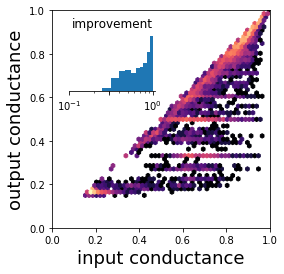

In [21]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='FlowImprove', nthreads=24, timeout=1000000, **{"delta": 0.00001})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'FlowImprove' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


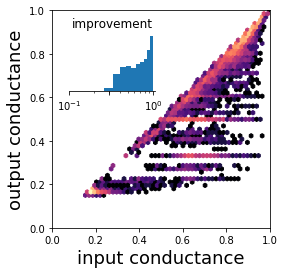

In [22]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.3})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_3' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


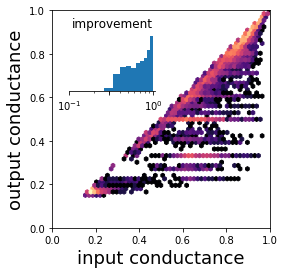

In [23]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.6})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_6' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


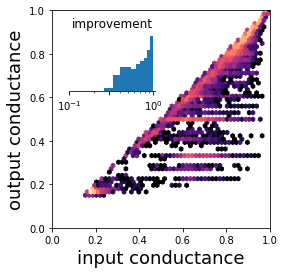

In [24]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.9})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_9' + "-ncp-"+'JH'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

In [ ]:
cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_JH.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_JH.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]

cuts_acl_flow = np.load('results/cuts_acl_flow_JH.npy')
cuts_acl_flow = cuts_acl_flow[()]

f1score_acl_flow = np.load('results/f1score_acl_flow_flowImprove_JH.npy')
f1score_acl_flow = f1score_acl_flow[()]

cuts_acl_flow_mqi = np.load('results/cuts_acl_flow_mqi_JH.npy')
cuts_acl_flow_mqi = cuts_acl_flow_mqi[()]

f1score_acl_flow_mqi = np.load('results/f1score_acl_flow_mqi_JH.npy')
f1score_acl_flow_mqi = f1score_acl_flow_mqi[()]

cuts_acl_flow_localflowImprove_parameter1 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter1 = cuts_acl_flow_localflowImprove_parameter1[()]

f1score_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_JH.npy')
f1score_acl_flow_localflowImprove_parameter1 = f1score_acl_flow_localflowImprove_parameter1[()]

cuts_acl_flow_localflowImprove_parameter2 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter2 = cuts_acl_flow_localflowImprove_parameter2[()]

f1score_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_JH.npy')
f1score_acl_flow_localflowImprove_parameter2 = f1score_acl_flow_localflowImprove_parameter2[()]

cuts_acl_flow_localflowImprove_parameter3 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_JH.npy')
cuts_acl_flow_localflowImprove_parameter3 = cuts_acl_flow_localflowImprove_parameter3[()]

f1score_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_JH.npy')
f1score_acl_flow_localflowImprove_parameter3 = f1score_acl_flow_localflowImprove_parameter3[()]

In [ ]:
experiment = (0,1289)
ref_set = list(cuts_best_cond_acl[experiment])

In [ ]:
# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(ref_set))
print("F1score before improvement:",f1score_best_cond_acl[experiment])

# Conductance and F1score for MQI
output_flow_mqi = list(cuts_acl_flow_mqi[experiment])
print("Conductance MQI:",g.compute_conductance(output_flow_mqi))
print("F1score MQI:",f1score_acl_flow_mqi[experiment])

# Conductance and F1score for FlowImprove
output_flowI = list(cuts_acl_flow[experiment])
print("Conductance FlowImprove:",g.compute_conductance(output_flowI))
print("F1score FlowImprove:",f1score_acl_flow[experiment])

# Conductance and F1score for Local FlowImprove delta_1
output_LocalflowI1 = list(cuts_acl_flow_localflowImprove_parameter1[experiment])
print("Conductance Local FlowImprove 1:",g.compute_conductance(output_LocalflowI1))
print("F1score Local FlowImprove 1:",f1score_acl_flow_localflowImprove_parameter1[experiment])

# Conductance and F1score for Local FlowImprove delta_2
output_LocalflowI2 = list(cuts_acl_flow_localflowImprove_parameter2[experiment])
print("Conductance Local FlowImprove 2:",g.compute_conductance(output_LocalflowI2))
print("F1score Local FlowImprove 2:",f1score_acl_flow_localflowImprove_parameter2[experiment])

# Conductance and F1score for Local FlowImprove delta_3
output_LocalflowI3 = list(cuts_acl_flow_localflowImprove_parameter3[experiment])
print("Conductance Local FlowImprove 3:",g.compute_conductance(output_LocalflowI3))
print("F1score Local FlowImprove 3:",f1score_acl_flow_localflowImprove_parameter3[experiment])

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[ref_set] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in ref_set:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_input.png'
          )

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flow_mqi] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flow_mqi:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_mqi.png'
          )

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flowI] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flowI:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_flowI.png'
          )

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI1] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI1:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI1.png'
          )

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI2] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI2:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI2.png'
          )

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI3] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI3:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/jh_demonstration_output_LocalflowI3.png'
          )